# Testing STFT solver implemented on STM32

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
import csv

from DSP_prototype import DSP_algorithms
import tensorflow as tf

2025-01-20 14:35:41.026482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737380141.087670   12818 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737380141.106577   12818 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 14:35:41.235099: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Audio and STFT files path

In [292]:
audio_file = "../Data_acquisition/data/audio/8kHz_sampling/stop_fs=8kHz_16.csv"
stft_file = "../Data_acquisition/data/stft/8kHz_sampling/stft_right_fs=8kHz_22.csv"

In [293]:
audio_data = []
with open(audio_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        audio_data.append(float(row['y']))  # Convert to int if y is numeric

audio_data = np.array(audio_data, dtype=np.float32)
print(f"Data length before resampling: {len(audio_data)}")
print(f"Data type before resampling: {type(audio_data[0])}")
display.Audio(audio_data, rate=8000, autoplay=False)

Data length before resampling: 8000
Data type before resampling: <class 'numpy.float32'>


## STFT using implemented Python solver

Number of frames: 61
signal_shape: (8000,)
STFT matrix shape: (129, 61)


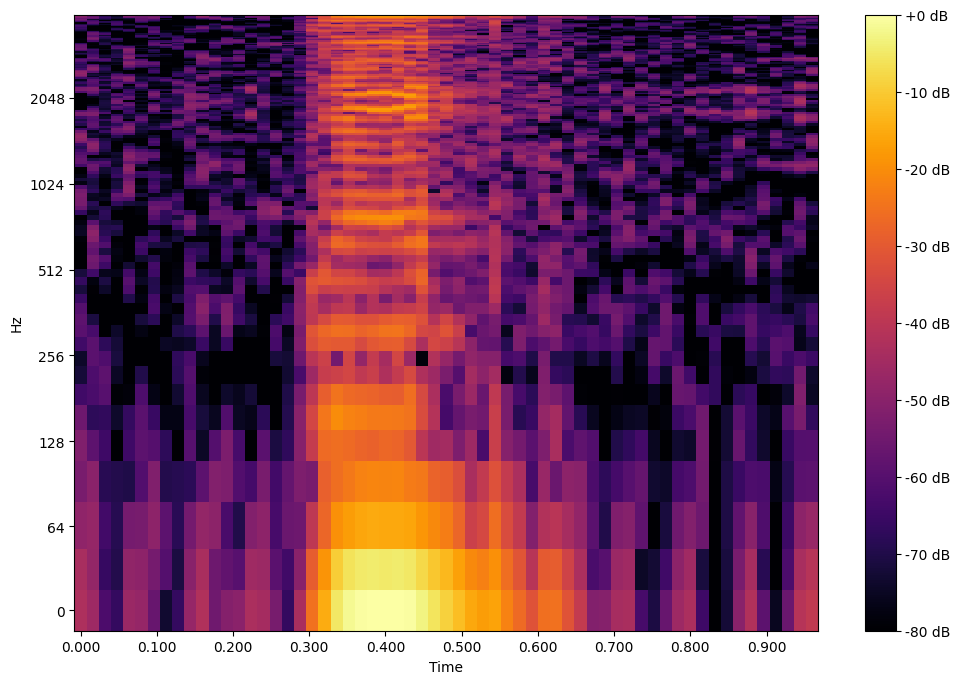

In [134]:
fs = 8e3
window_size = 256
hop_size = 128

stft_matrix, freq_bins, time_frames = DSP_algorithms.stft(audio_data, fs=fs, N=window_size, hop_size=hop_size,
                                                          window_type='hann', verbose=True)

print(f"STFT matrix shape: {stft_matrix.shape}")

S_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [90]:
def noise_reduction_gain_function(noisy_signal, fs, frame_size=1024, overlap=512, noise_frames=10):
    """
    Perform noise reduction using the gain function method.
    
    Parameters:
        noisy_signal (numpy array): The noisy input signal.
        fs (int): Sampling frequency of the signal.
        frame_size (int): Size of each STFT frame (default=1024).
        overlap (int): Overlap between frames (default=512).
        noise_frames (int): Number of initial frames to estimate noise power (default=10).
    
    Returns:
        clean_signal (numpy array): The denoised signal.
    """
    # STFT of the noisy signal
    f, t, Zxx = scipy_stft(noisy_signal, fs, nperseg=frame_size, noverlap=overlap)
    
    # Magnitude and phase of the noisy signal
    magnitude = np.abs(Zxx)
    print(np.max(magnitude))
    phase = np.angle(Zxx)
    print("phase", phase.shape)
    
    # Estimate noise power spectrum from the first few frames
    noise_power = np.mean(magnitude[:, :noise_frames]**2, axis=1, keepdims=True)
    print(noise_power)
    
    # Compute SNR and gain function
    noisy_power = magnitude**2
    snr = np.maximum(noisy_power / noise_power - 1, 0)  # SNR must be non-negative
    print(np.max(snr))
    gain = snr / (1 + snr)  # Wiener filter-based gain function
    print(snr.shape)
    print(type(gain))
    print(gain.shape)
    
    # Apply the gain function to the magnitude spectrum
    cleaned_magnitude = gain * magnitude
    
    # Reconstruct the cleaned signal
    cleaned_spectrogram = cleaned_magnitude * np.exp(1j * phase)
    _, clean_signal = istft(cleaned_spectrogram, fs, nperseg=frame_size, noverlap=overlap)
    
    return clean_signal

In [38]:
def downsample_image_fixed(input_image, input_height, input_width, target_height, target_width):
    """
    Downsamples an image using bilinear interpolation, matching TensorFlow's tf.image.resize.
    """
    # Calculate scaling factors
    scale_height = input_height / target_height
    scale_width = input_width / target_width

    # Prepare the output image
    output_image = np.zeros((target_height, target_width), dtype=np.float32)

    for y in range(target_height):
        for x in range(target_width):
            # Map target pixel to source coordinates
            src_y = (y + 0.5) * scale_height - 0.5
            src_x = (x + 0.5) * scale_width - 0.5

            # Calculate integer bounding box of the source coordinates
            y0 = int(np.floor(src_y))
            x0 = int(np.floor(src_x))
            y1 = min(y0 + 1, input_height - 1)
            x1 = min(x0 + 1, input_width - 1)

            # Handle edge cases for the coordinates
            y0 = max(0, y0)
            x0 = max(0, x0)

            # Compute interpolation weights
            dy = src_y - y0
            dx = src_x - x0

            # Bilinear interpolation
            v00 = input_image[y0 * input_width + x0]
            v01 = input_image[y0 * input_width + x1]
            v10 = input_image[y1 * input_width + x0]
            v11 = input_image[y1 * input_width + x1]

            # Avoid negative weights
            value = (
                v00 * (1 - dx) * (1 - dy) +
                v01 * dx * (1 - dy) +
                v10 * (1 - dx) * dy +
                v11 * dx * dy
            )

            # Ensure no negative values (important if inputs are strictly non-negative)
            value = max(0, value)

            # Assign to the output image
            output_image[y, x] = value

    return output_image

## STFT using implemented STM32 solver

In [64]:
stft_data = []
with open(stft_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        stft_data.append(float(row['stft_value']))  # Convert to int if y is numeric

stft_data = np.array(stft_data, dtype=np.float32)
print(f"stft_data shape: {stft_data.shape}")

stft_data shape: (7869,)


In [53]:
S = np.zeros(129*61, dtype=np.complex128)

In [244]:
for i in range(129*61):
    S[i] = stft_data[2*i] + 1j * stft_data[2*i+1]

STFT matrix shape: (129, 61)


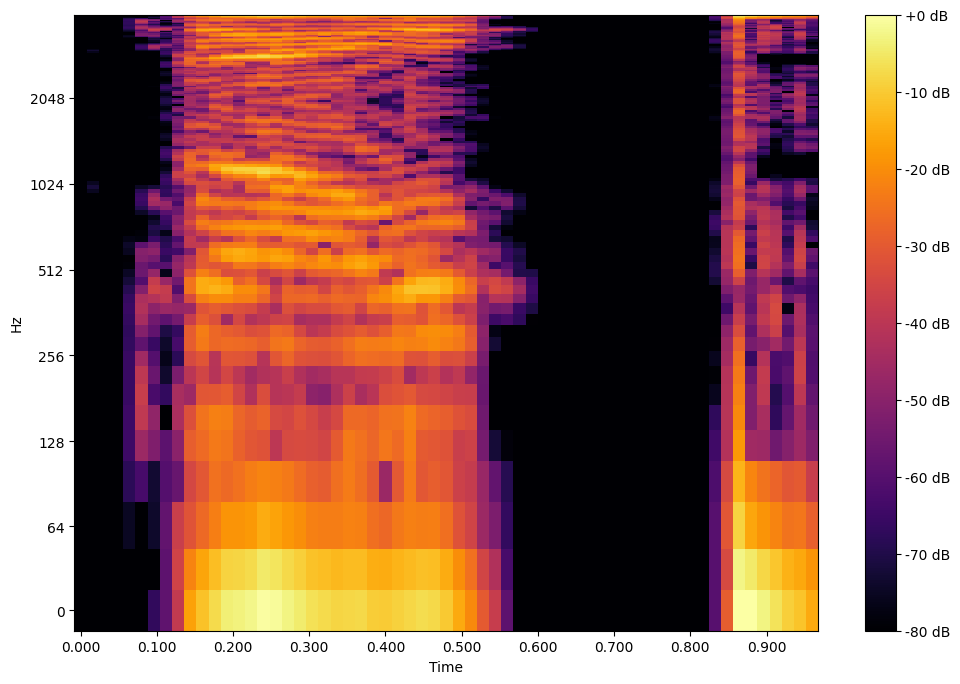

In [65]:
hop_size = 128
N = 256

num_frames = (len(stft_data) - (N // 2 + 1)) // (N // 2 + 1) + 1
frame_length = N // 2 + 1

if len(stft_data) != num_frames * frame_length:
    raise ValueError("STFT data length does not match expected frame count and frequency")

stft_matrix = np.reshape(stft_data, (frame_length, 61), )
print(f"STFT matrix shape: {stft_matrix.shape}")

S_db = librosa.amplitude_to_db(stft_matrix, ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [288]:
from scipy.signal import istft
_, clean_signal = istft(S.reshape(129, 61), fs, nperseg=256, noverlap=128)

In [289]:
display.Audio(clean_signal, rate=8000)

In [13]:
S_db.shape

(129, 61)

STFT matrix shape: (129, 61)


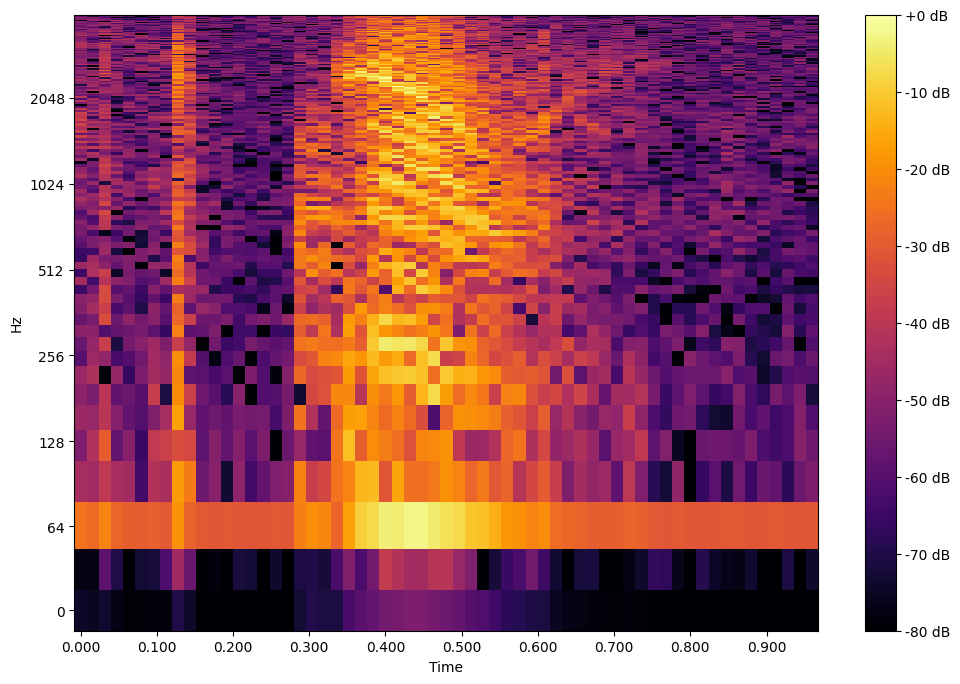

In [8]:
hop_size = 128
N = 256

num_frames = (len(stft_data) - (N // 2 + 1)) // (N // 2 + 1) + 1
frame_length = N // 2 + 1

if len(stft_data) != num_frames * frame_length:
    raise ValueError("STFT data length does not match expected frame count and frequency")

stft_matrix = np.reshape(stft_data, (frame_length, num_frames), order='F')
print(f"STFT matrix shape: {stft_matrix.shape}")

S_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()